# Helper functions

In [1]:
import d6tflow
import numpy as np

import d6tflow
import sklearn.datasets, sklearn.ensemble, sklearn.linear_model
import pandas as pd
from pathlib import Path

Loading postgres module without psycopg2 installed. Will crash at runtime if postgres functionality is used.


Welcome to d6tflow! For Q&A see https://github.com/d6t/d6tflow


In [2]:
X = np.random.randn(100,3)
y = np.random.randn(100,1)

In [3]:
d6tflow.settings.dirpath

WindowsPath('data')

# d6tflow Transformer (NodeTransformer)
> a d6tflow wrapper for a sklearn estimator

In [24]:
from pathlib import Path
import os
from warnings import warn

import d6tflow
from pathlib import Path
from collections import defaultdict

from sklearn.base import BaseEstimator

import cloudpickle

In [37]:
def camelize(s):
    if(len(s) == 0):
        return
    s1 = ''
    s1 += s[0].upper()        
    
    for i in range(1, len(s)):
        
        if not s[i].isalnum():
            s1 += ''
            i += 1                    
        elif (s[i] == ' '):
            s1 += s[i + 1].upper()
            i += 1
        elif(s[i - 1] != ' '):
            s1 += s[i]                
        
    while True:
        if s1[0].isnumeric():
            s1 = s1[1:] + s1[0]            
        else:
            break
            
    return s1    

def is_camel_case(s):    
    return (camelize(s) == s) and (s != '')

In [38]:
def _validate_name(name):
    #if isinstance(name,str):
    #        if is_camel_case(name):
    #            return name
    #        else:
    #            raise ValueError(f'name must be a valid camelcase str, try {camelize(name)}')
    #else:
    #    raise TypeError(f'name must be str, not {type(name)}')
    return name

# Classes

In [39]:
class Pickler():
    '''
    InputOutput Node for d6tflow application.
    Does nothing during fit.
    During transform, pickles X under `<d6tflow.settings.dirpath>/self.name` path and returns path
    '''
    def __init__(self, name):        
        self.name = _validate_name(name)        
        
        self.__path = None
        return
    
    @property
    def path(self,):                
        return self.__path        
        
    
    def pickle(self, X, override = False):
        #assigns path only after pickling, so that it raises error when trying to unpickle before pickling
        self.__path = Path(d6tflow.settings.dirpath)/'IO'/(self.name+'.pkl')
        
        #create folder if does not exist
        if not self.path.parent.exists():
            os.makedirs(self.path.parent)
        
        if override:                        
            if self.path.exists():
                warn(f'File already exists under {self.path.absolute()} and will be overriden.')                                    
            else:
                pass
        else:
            if self.path.exists():
                raise FileExistsError(f'A file already exists under {self.path.absolute()}. If you want to override, set override param to True')
            else:
                pass
        
        #override if reached this point
        with open(self.path, 'wb+') as f:
                cloudpickle.dump(X, f)                
        
        return self
    
    def unpickle(self,):
        try:
            with open(self.path, 'rb') as f:
                content = cloudpickle.load(f)
            return content
        
        except TypeError as e:
            raise TypeError(str(e)+ '. Check if path is valid or not None. If so try running .pickle() before trying to unpickle')
            
    
    def force_unpickle(self, file_path):
        '''
        forced unpickling of file in file_path
        '''
        with open(file_path, 'rb') as f:
            content = cloudpickle.load(f)
        return content
    
    def reset(self,):
        '''
        deletes pickled file under path
        '''
        if self.path.exists():
            os.remove(self.path)        
        self.__path = None
        return self
    
class PicklerTransformer(Pickler, BaseEstimator):
    '''
    Sklearn verstion of Pickler
    during fit, pickles a dict containing X, y and kwargs passed to fit
    on trnsform, unpickles and returns the dict
    '''
    def __init__(self, name, override_on_fit = False):
        self.override_on_fit = override_on_fit
        super().__init__(name)
        return
    
    def fit(self, X, y = None, **kwargs):
        output_dict = {'X':X, 'y':y, 'kwargs':kwargs}        
        self.pickle(output_dict, override = self.override_on_fit)
        self.is_fitted_ = True
        return self
    
    def transform(self, X = None, **kwargs):
        return self.unpickle()
    
    def reset(self,):
        super().reset()
        self.is_fitted_ = False
        return self

# Task Factories

In [130]:

def _process_multiple_kwargs(kwargs_list):
    '''
    takes a list of kwargs and returns a kwargs dict with parameters as lists
    '''
    
    keys = []
    for kwargs in kwargs_list:
        keys += list(kwargs.keys())
    
    keys = list(set(keys))
    #TODO: define better strategy
    #dict will contain __EMPTY_KW_PARAM__ if parameter has not been passed
    dict_kwargs = {key:['__EMPTY_KW_PARAM__']*len(kwargs_list) for key in keys}
    
    for idx in range(len(kwargs_list)):
        kwargs = kwargs_list[idx]
        for key in kwargs:
            dict_kwargs[key][idx] = kwargs[key]
    
    return dict_kwargs

def unpack_fit_inputs(inputs):
    '''
    unpacks result of Task.inputLoad(), according to defined convention for fit tasks
    returns tuple (X, kwargs)
    '''    
    if len(inputs) < 1:
        raise ValueError('No inputs to unpack')
    
    #checks if keys contains X y and kwargs
    if (set(['X', 'kwargs']) & set(inputs.keys())) == set(['X', 'kwargs']):
        #keep as list even for single inputs for consistency
        X, kwargs = [inputs['X']], [{k:v for k,v in inputs.items() if not k == 'X'}]
    
    else:
        X, kwargs = [], []   
        for key in inputs:
            X.append(inputs[key]['X'])            
            kwargs.append({k:v for k,v in inputs[key].items() if not k == 'X'})
    
        kwargs = _process_multiple_kwargs(kwargs)
    
    #return tuples
    X, kwargs = tuple(X), {k:tuple(v) for k,v in kwargs.items()}
    return X, kwargs

def unpack_transform_inputs(inputs):
    '''
    unpacks result of Task.inputLoad(), according to defined convention for transform tasks
    returns tuple (estimator, X, kwargs)
    '''
    
    if len(inputs) < 1:
        raise ValueError('No inputs to unpack')
            
    #retrieves estimator (will always be dict since transform needs at least 
    #two inputs always: estimator (from fit) and input)    
    estimator = inputs[0]
    #remove estimator from inputs
    del inputs[0]
    
    X, kwargs = unpack_fit_inputs(inputs)
    
    return estimator, X, kwargs

In [163]:
#TODO: disable fit and transform method for singletons (using @property ro raise a erro when attr called), enable only in pipeline
def input_task_factory(task_name, **kwargs):
    '''
    task to dump any object as a pkl file
    '''    
    class DumpTask(d6tflow.tasks.TaskPickle):
        def run(self,):            
            self.save(kwargs)
            return
    
    DumpTask.__name__ = _validate_name(task_name)
    return DumpTask    

def fit_task_factory(task_name, estimator, dependencies = [], y_task = None):
    '''
    creates a task to fit estimator    
    '''
    assert isinstance(dependencies, (list, tuple)), f'dependencies should be tuple or list, not {type(dependencies)}'
        
    class FitTask(d6tflow.tasks.TaskPickle):
        def run(self,):
            inputs = self.inputLoad()
            #reset and rerun y_loader
            y_task().reset(confirm = False)
            y_task().run()
            y = y_task().outputLoad()
            X, kwargs = unpack_fit_inputs(inputs)
            estimator.fit(X, y, **kwargs)            
            self.save(estimator)
            return
    
    #different syntax for @requires wrapper    
    if len(dependencies) > 0:        
        FitTask = d6tflow.requires(*dependencies)(FitTask)
    
    FitTask.__name__ = _validate_name(task_name)
    return FitTask

def transform_task_factory(task_name, fit_task, input_dependencies = [], transform_method = 'transform'):
    '''
    receives X and **kwargs from dependencies, performs and saves result from estimator.transform()
    '''
    assert isinstance(input_dependencies, (list, tuple)), f'dependencies should be tuple or list, not {type(input_dependencies)}'
    
    class TransformTask(d6tflow.tasks.TaskPickle):
        def run(self,):
            inputs = self.inputLoad()
            estimator, X, kwargs = unpack_transform_inputs(inputs)
            results = getattr(estimator, transform_method)(X, **kwargs)
            self.save({'X':results})
            return
    
    
    TransformTask = d6tflow.requires(fit_task, *input_dependencies)(TransformTask)
    
    TransformTask.__name__ = _validate_name(task_name)
    return TransformTask

# Wrappers
> make to main wrappers: Skleaern way and keras way

In [164]:
def _validate_input_nodes(input_nodes, child_name):
    '''
    checks if input nodes are valid (NodeTransformer).
    If not NodeTransformer but valid BaseEstimator instance, wrapps BaseEstimator in NodeTransformer
    '''
        
    processed_nodes = []
    for node in input_nodes:
        if isinstance(node, NodeTransformer):
            processed_nodes.append(node)
        
        elif isinstance(node, BaseEstimator):
            node = NodeTransformer(node, 'Parent' + child_name)
            process_nodes.append()

In [196]:
from sklearn.exceptions import NotFittedError

class BaseDagNode(BaseEstimator):
    '''
    Base class for nodes
    '''
    def __str__(self,):
        return self.name        
        

class InputTransformer(BaseDagNode):
    
    def __init__(self, name = None, reset_cache = True):
                        
        self.reset_cache = reset_cache
        
        if name is None:
            self.name = 'Input' + str(id(self))
        else:
            self.name = _validate_name(name)
        #input task placeholder, to access this task, fit_task and input_task aliases will be created, for consistency
        self.__input_task = input_task_factory(self.name, X = {})
        return
    
    
    @property
    def input_task(self,):                
        return self.__input_task
            
    @property
    def fit_task(self,):
        return self.input_task
    
    @property
    def transform_task(self,):
        return self.input_task
    
    def _reset_transform_cache_in(self,):
        '''
        does nothing, since theres no input to the input node,
        method exists only for consistency
        '''
        return
    
    def _reset_transform_cache_out(self,):
        '''
        resets output cache
        '''
        self.input_task.reset(confirm = False)
        return
        
    def _reset_fit_cache(self,):
        '''
        does nothing, since theres no state to input node,
        method exists only for consistency
        '''
        return
    
    def fit(self, X, **kwargs):        
        '''
        creates input task. saves kwargs
        '''
        kwargs = {'X':X, **kwargs}
        self.__input_task = input_task_factory(self.name, **kwargs)
        self.is_fitted_ = True
        return self
    
    def transform(self, X = None, reset_cache = None, **kwargs):        
        self.input_task.reset(confirm = False)
        self.input_task.run()
        result = self.input_task.outputLoad()
        if reset_cache is None:
            #if none is passed, use defaut value from constructor
            reset_cache = self.reset_cache
        if reset_cache:
            self._reset_transform_cache_out()
        return result
    
    
class NodeTransformer(BaseDagNode):
    
    def __init__(self, estimator, input_nodes = [], name = None):
        
        self.estimator = estimator
        
        if not isinstance(input_nodes, (list, tuple)) and (len(input_nodes) > 0):
            raise TypeError(f'input_nodes should be a list or tuple with length greater than 0, got {input_nodes}')
        self.input_nodes = input_nodes
        
        if name is None:
            self.name = 'Task' + str(id(self))
        else:
            self.name = _validate_name(name)                                        
        
        #placeholder for __y_loader
        self.__y_loader = None
        
        return
    
            
    def set_y_loader(self, y_loader):
        '''
        sets self.__y_loader, needed during fit
        '''
        self.__y_loader = y_loader
        return
    
    @property
    def y_loader(self,):
        return self.__y_loader
    
    @property
    def fit_task(self,):
        if self.y_loader is None:
            raise NotFittedError('Should set y_loader prior to accessing fit_task')
        return fit_task_factory('Fit' + self.name, self.estimator, [i.transform_task for i in self.input_nodes], self.y_loader)
        
    @property
    def transform_task(self):        
        '''
        transform task property.
        
        '''
        self._make_transform_task()
        return self.__transform_task
    
    def _fit(self, reset_cache = True):        
        
        #reset cache of transform nodes        
        if reset_cache:
            self._reset_transform_cache_in()
        
        #reset fit cache (estimator state) 
        self._reset_fit_cache()
        
        #run task
        d6tflow.Workflow(self.fit_task).run()        
        return self
    
    def fit(self, X, y = None, **kwargs):
        raise NotImplementedError('To fit this estimator, create a DAG and call fit in this instance')
    
    def _reset_fit_cache(self):        
        self.fit_task().reset(confirm = False)
        return
    
    def _reset_transform_cache_out(self):        
        self.transform_task().reset(confirm = False)
        return
    
    def _reset_transform_cache_in(self):
        [node.transform_task().reset(confirm = False) for node in self.input_nodes]
        return
    
    def _make_transform_task(self, transform_method = 'transform'):
        '''
        creates mangled (private) __transform_task attribute
        '''
        
        self.__transform_task = transform_task_factory(
            'Transform' + self.name, self.fit_task, [i.transform_task for i in self.input_nodes], transform_method = transform_method
        )
        
        return
        
    def _infer(self, X, infer_method, reset_cache = True, **kwargs):        
        self._make_transform_task(transform_method = infer_method)
        #reset cache
        if reset_cache:
            #resets input node cache
            self._reset_transform_cache_in()
        #out cache is reseted anyways
        self._reset_transform_cache_out()        
        #run task
        workflow = d6tflow.Workflow(self.transform_task)
        workflow.run()        
        return workflow.outputLoad()
    
    def transform(self, X, **kwargs):
        return self._infer(X, infer_method = 'transform', **kwargs)
    
    def predict(self, X, **kwargs):
        return self._infer(X, infer_method = 'predict', **kwargs)
    
    def predict_proba(self, X, **kwargs):
        return self._infer(X, infer_method = 'predict_proba', **kwargs)
        

# PipelineSession

In [197]:

class PipelineSession():
    '''
    sets d6tflow.settings.dirpath to pipeline name on open
    on close, resets d6tflow.settings.dirpath to default
    '''
    def __init__(self, pipeline_name):
        self.session_name = Path(pipeline_name)
        self.default_name = d6tflow.settings.dirpath
        return
    
    def __enter__(self,):
        d6tflow.settings.dirpath = self.session_name
        return
    
    def __exit__(self, exc_type, exc_value, traceback):
        d6tflow.settings.dirpath = self.default_name
        return
    
        
    

# Serialization functionalities

In [198]:
def pickle_load(path, **kwargs):
    '''
    abstraction for loading object
    '''
    path = Path(path)
    try:
        with open(path.absolute(), 'rb') as f:
             obj = cloudpickle.load(f, **kwargs)
        
    except Exception as e:            
        raise Exception(f'{str(e)} [{path.absolute()}]')
    
    return obj

def pickle_dump(obj, path, **kwargs):
    '''
    abstraction for dumping objects
    '''
    path = Path(path)
    try:
        with open(path.absolute(), 'wb') as f:
             cloudpickle.dump(obj, f, **kwargs)                            
        
    except Exception as e:            
        raise Exception(f'{str(e)} [{path.absolute()}]')
    
    return


def recursive_dict():
    return defaultdict(recursive_dict)

def undefault_dict(dictionary):
    '''
    recursively transforms a default dicts into dicts
    '''
    for key in dictionary.keys():
        if isinstance(dictionary[key], defaultdict):
            dictionary[key] = undefault_dict(dict(dictionary[key]))
        
        elif isinstance(dictionary[key], dict):
            dictionary[key] = undefault_dict(dictionary[key])
        
        else:            
            return dictionary
    
    dictionary = dict(dictionary)
    return dictionary
            
def recursive_assign(dictionary, keys, value):
    
    '''
    assigns value to dictinary[keys[0]][keys[1]]...[keys[n]] position    
    '''
    
    if len(keys) == 1:
        dictionary[keys[0]] = value
        return dictionary
    
    else:
        dictionary[keys[0]] = recursive_assign(dictionary[keys[0]], keys[1:], value)
    
    return dictionary

def folder_to_dict(root_folder, patterns = ['*.pickle','*.pkl','*.sav']):
    
    '''
    creates a dict of unpickled objects found recursively under root folder and matching patterns
    '''
        
    obj_dict = {}
    root_folder = Path(root_folder)
    
    file_paths = []
    for pattern in patterns:
        file_paths += root_folder.rglob(pattern)
    
    for path in file_paths:        
        obj = pickle_load(path)
        obj_dict[str(path)] = obj
    
    return obj_dict

def dict_to_folder(dictionary, path = '.', assert_new_folder = True, override = False):
    
    '''
    creates folder structure according to dictionary. Can ensure that no folders with the same name 
    are found under path and to raise errors in case the same filenames already exists.
    '''
    root_path = Path(path)
    for key in dictionary:
        
        filepath = Path(key)        
        if assert_new_folder:
            dirpath = root_path/filepath.parts[0]
            if dirpath.exists():
                raise FileExistsError(f'{dirpath.absolute()} already exists.')        
        
        filepath = root_path/filepath
        if filepath.exists():
            if override:
                warn(f'{filepath.absolute()} already exists and will be overriden.')                
            else:
                raise FileExistsError(f'{filepath.absolute()} already exists.')
        
        pickle_dump(dictionary[key], filepath)
            
    return

# Model

In [ ]:
# viz
import pydot_ng as pydot
def model_to_dot(graph,
                 show_layer_names=True,
                 rankdir='TB',
                 expand_nested=False,
                 dpi=96,
                 subgraph=False):

    def add_edge(dot, src, dst):
      if not dot.get_edge(src, dst):
        dot.add_edge(pydot.Edge(src, dst))

    #create dot object
    dot = pydot.Dot()
    dot.set('rankdir', rankdir)
    dot.set('concentrate', True)
    dot.set('dpi', dpi)
    dot.set_node_defaults(shape='record')

    for node in graph:
        label = '{}: {}'.format(node.__class__.__name__,node.name)
        mode = ''
        if node.fit_only:
            mode = 'fit_only'
        elif node.transform_only:
            mode = 'transform_only'
        else:
            mode = 'fit and transform'

        if not node.name in [None,'None','NoneType']:
            name = node.name
        else:
            name = 'Unnamed'

        type_ = node.estimator.__class__.__name__
        if type_ == 'NoneType':
            type_ = node.__class__.__name__

        #create node_labels

        if not node.is_callable:
            required_input_labels = node.required_inputs
            optional_input_labels = node.optional_inputs
            output_labels = node.allowed_outputs
        else:
            required_input_labels = node.required_inputs['fit']
            optional_input_labels = node.optional_inputs['fit']
            output_labels = node.allowed_outputs['fit']

        if isinstance(node, Inputer):
            label = "Inputer\n%s\n%s\n%s" % (
                name,
                mode,
                list(node.required_inputs['fit'])
            )
        elif isinstance(node, Renamer):
            label = "Renamer\n%s\n%s| %s" % (
                name,
                mode,
                node.mapper
            )
        else:
            label = "%s\n%s\n%s|{required_input:|optional_input:|output:}|{{%s}|{%s}|{%s}}" % (
                type_ ,
                name,
                mode,
                required_input_labels,
                optional_input_labels,
                output_labels)


        node = pydot.Node(node.name, label=label)
        dot.add_node(node)
    for edge in graph.edges:
        add_edge(dot, edge[0].name, edge[1].name)

    return dot


In [199]:
def _traverse_upstream(output_node):  
    '''
    traverses all nodes in the dag that ends at output_node.
    returns nodes and directed edges
    '''
    def __traverse_upstream(node, traversed_nodes = [], traversed_edges = []):
        
        assert isinstance(node, BaseDagNode)
        
        traversed_nodes.append(node)
        
        if not isinstance(node, InputTransformer): #keep traversing until reaches an InputNode
            
            for input_node in node.input_nodes:
                traversed_edges.append((input_node, node))
                __traverse_upstream(input_node, traversed_nodes)        

        return traversed_nodes, traversed_edges
    
    traversed_nodes, traversed_edges = __traverse_upstream(output_node)
    return traversed_nodes, traversed_edges

In [239]:
import networkx as nx
from sklearn.base import clone

#TODO: define best name for class
class DAGEstimator(BaseDagNode):
    
    def __init__(self, output_node, name):        
        self.output_node = output_node
        self.name = _validate_name(name)                
        return                                
    
    @property
    def nodes_dict(self,):
        return {node.name:node for node in self.graph}
    
    @property
    def graph(self,):
        return self.__graph
    
    @property
    def input_nodes(self,):
        return tuple([i for i in self.__graph if isinstance(i, InputTransformer)])
    
    @property
    def input_nodes_dict(self,):
        return {i.name:i for i in self.__graph if isinstance(i, InputTransformer)}
    
    def session_run(self, method):
        '''
        runs a method safely inside a pipelinesession
        '''
        
        def session_wrapped_method(*args, **kwargs):
            with PipelineSession(pipeline_name = self.name):
                result = method(*args, **kwargs)
            return result
            
        return session_wrapped_method
        
    
    def _make_graph(self):                
        nodes,edges = _traverse_upstream(self.output_node)
        
        g = nx.DiGraph()
        g.add_nodes_from(nodes)
        g.add_edges_from(edges)
        self.__graph = g
        return
    
    def _reset_transform_cache_in(self,):
        '''
        reset input of transform nodes
        '''
        
        for node in self.graph:
            #reset input of transform nodes
            node._reset_transform_cache_in()
        return
    
    def _reset_transform_cache_out(self,):
        '''
        reset input of transform nodes
        '''
                
        self.output_node._reset_transform_cache_out()
        return
    
    def _reset_fit_cache(self,):
        '''
        reset input of transform nodes
        '''
                
        for node in self.graph:
            #reset estimators states of nodes in DAG
            node._reset_fit_cache()
        return
    
    def _check_graph(self,):
        
        if not nx.is_connected(nx.Graph(self.__graph)):
            raise Exception('DAG has disconected parts')
        
        
        if not nx.is_directed_acyclic_graph(self.__graph):
            raise Exception('Infered graph is not a DAG')
        
        
        repeated_names = set(
            [x.name for x in list(self.graph.nodes) if [i.name for i in self.graph.nodes].count(x.name) > 1])
        if repeated_names:
            raise NameError(f'Node names should be unique. Got repeated names: {repeated_names}')
        
        return True    
    
    def _check_X(self, X):
        
        '''
        checks if X is valid input
        '''
        
        if isinstance(X, (tuple, list)):
            if len(X) != len(self.input_nodes):
                raise ValueError(f'DAG has {len(self.input_nodes)} input nodes, got {len(X)} inputs in X')
        
        elif isinstance(X, dict):                        
            if set(X) == set(self.input_nodes_dict):
                raise ValueError(f'DAG input node names are {set(self.input_nodes_dict)}, got {set(X)} keys in X')
        
        else:
            raise TypeError(f'X should be tuple or list of inputs or dict, got {type(X)}')
        
        return
        
    def _populate_input_nodes(self, X):
        '''
        populate input nodes with X passed (list or dict)
        '''
        if isinstance(X, (tuple, list)):
            for idx in range(len(self.input_nodes)):
                
                #TODO: define how to pass **kwargs for each input node
                self.input_nodes[idx].fit(X[idx])
        
        elif isinstance(X, dict):
            for key in range(len(self.input_nodes_dict)):
                self.input_nodes_dict[key].fit(X[key])
                
        else:
            raise TypeError(f'X should be list, tuple or dict, got {type(X)}')
        
        return                    
    
    def fit(self, X, y = None, **kwargs):
        #def method to be ran inside run_session
        def _fit(X, y = None, **kwargs):
            '''
            X must be a list or dict pointing to input Nodes
            '''
            self._make_graph()
            self._check_graph()
            #check inputs
            self._check_X(X)
            # create y_loader        
            y_loader = input_task_factory(self.name + 'Y', y = y)

            #pass y to all transformers in the pipeline
            #"populate" all nodes with y
            for node in self.__graph:
                #if not input node, assign y
                if isinstance(node, NodeTransformer):
                    node.set_y_loader(y_loader)                            

            #reset transform and fit cache
            self._reset_transform_cache_in()
            self._reset_fit_cache()
            #populate input nodes with X
            self._populate_input_nodes(X)                            
            #recursively fit output node                            
            self.output_node._fit()

            #TODO: check if it will be necessary to clone in order to grab different parts of the pipeline and reuse it in other pipelines (like in keras)        
            return self
        
        #run _fit method safely        
        self.session_run(_fit)(X, y = None, **kwargs)
        return self
    
    def _infer(self, X, infer_method, reset_cache = True, **kwargs):
        
        #def private infer method
        def infer(X, infer_method, reset_cache = True, **kwargs):

            if reset_cache:
                #reset transform cache
                self._reset_transform_cache_in()

            #populate input nodes with X
            self._populate_input_nodes(X)
            #infer        
            out = self.output_node._infer(X, infer_method, reset_cache, **kwargs)
            self.session_run(infer)
            return out
        
        #run infer method safely
        return self.session_run(infer)(X, infer_method, reset_cache = True, **kwargs)
    
    def transform(self, X, **kwargs):
        return self._infer(X, infer_method = 'transform', reset_cache = True, **kwargs)
    
    def sub_dag(self, name):
        '''
        returns a new DAG instance, having its output node defined by name
        '''
        return DAGEstimator(self.nodes_dict[name], self.name + 'SubDag' + name)
    
    def _create_states_directory(self,):
        '''
        creates directory with fitted estimators from some dict
        '''
    def __reppr__(self,):
        return self.name
    
    def _reduce_dag():
        '''
        creates a dictionary with all reference for reconstructing the dag (for serializing purposes)
        '''
        return
    
    def _reduce_states():
        '''
        creates a dict of objects, with their relative paths as keys , to pickle pipeline
        '''
        #node.fit_task().output().path <--- obj paths
    

In [247]:
from sklearn.preprocessing import FunctionTransformer
in1 = InputTransformer('Input1')
in2 = InputTransformer('Input2')
in3 = InputTransformer('Input3')

node1 = NodeTransformer(FunctionTransformer(np.prod), [in2,in1], 'prod1')
node2 = NodeTransformer(FunctionTransformer(np.sum), [node1,in3], 'sum1')
node3 = NodeTransformer(FunctionTransformer(np.prod), [node1,node2,in1, in2, in3], 'prod2')


node4 = NodeTransformer(FunctionTransformer(sum), [node1,node3,in1, in2, in3], 'sum_final')

In [248]:
dag = DAGEstimator(node4, 'Pipeline1').fit([4,2,3], 1)


===== Luigi Execution Summary =====

Scheduled 10 tasks of which:
* 10 ran successfully:
    - 1 Fitprod1()
    - 1 Fitprod2()
    - 1 Fitsum1()
    - 1 Fitsum_final()
    - 1 Input1()
    ...

This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



In [249]:
dag.transform([2,5,3])


===== Luigi Execution Summary =====

Scheduled 11 tasks of which:
* 11 ran successfully:
    - 1 Fitprod1()
    - 1 Fitprod2()
    - 1 Fitsum1()
    - 1 Fitsum_final()
    - 1 Input1()
    ...

This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



{'X': 3920}

In [250]:
colors = []
for node in dag.graph:
    if node in dag.input_nodes:
        colors.append('g')
    elif node == dag.output_node:
        colors.append('r')
    else:
        colors.append('b')


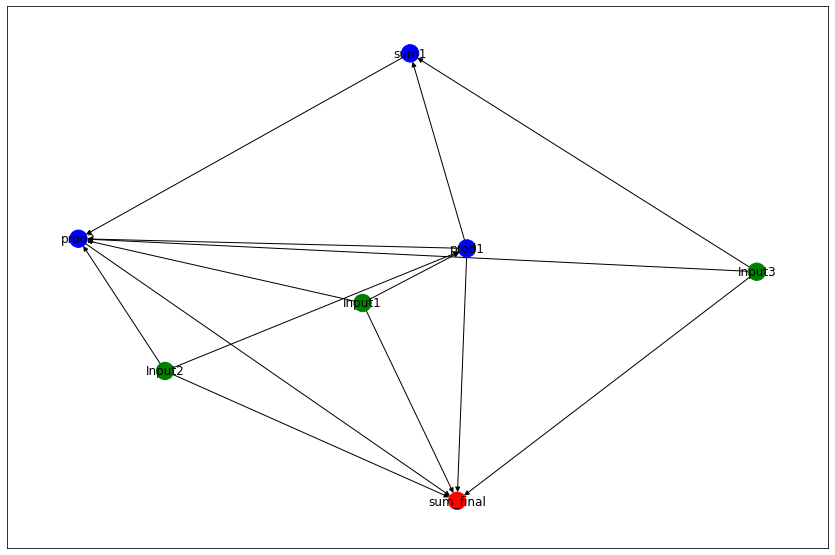

In [251]:
import matplotlib.pyplot as plt
nx.draw_networkx(dag.graph,node_color = colors)
nx.is_directed_acyclic_graph(dag.graph)

plt.subplots_adjust(left = -1, bottom = -1)

In [ ]:
#TODO: reset cache during fit and transform